In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import seaborn as sns
import matplotlib.pyplot as plt

# Introduction

When patients are admitted to hospital, it is often difficult to complete a comprehensive nutrition assessment. While a Subjective Global Assessment is often performed within 48-hours of admit, this relies on the ability of the patient or their proxies to provide accurate health histories.

The purpose of this project is to develop a supplemental screening tool to identify patients at high risk of protein-calorie malnutrition so that providers may involve Registered Dietians earlier in the admit. This will potentially reduce the incidences of missed malnutrition diagnoses and allow for ealier nutrition interventiions and maximize billing/compensation.

Data were obtained from the MIMIC-IV demo dataset (with plans to procure the full dataset at a later date).

## Data View

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/raphi-l/my-portfolio/refs/heads/main/datasets/mal_pt_data.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   subject_id                           275 non-null    int64  
 1   hadm_id                              275 non-null    int64  
 2   gender                               275 non-null    object 
 3   age                                  275 non-null    int64  
 4   admission_type                       275 non-null    object 
 5   admission_location                   275 non-null    object 
 6   marital_status                       263 non-null    object 
 7   race                                 275 non-null    object 
 8   hadm_id:1                            234 non-null    float64
 9   albumin_admit                        65 non-null     float64
 10  alkaline_phosphatase_admit           110 non-null    float64
 11  asparate_aminotransferase_admit 

In [ ]:
df.head()

,subject_id,hadm_id,gender,age,admission_type,admission_location,marital_status,race,hadm_id:1,albumin_admit,...,magnesium_admit,phosphate_admit,potassium_admit,potassium_whole_blood_admit,subject_id:1,height_in,weight_lb,bmi,blood_pressure,has_malnutrition
0,10004235,24181354,M,47,URGENT,TRANSFER FROM HOSPITAL,SINGLE,BLACK/CAPE VERDEAN,24181354.0,NaN,...,2.3,8.7,4.3,NaN,10004235.0,72.0,254.70,34.9,112/72,0
1,10009628,25926192,M,58,URGENT,TRANSFER FROM HOSPITAL,MARRIED,HISPANIC/LATINO - PUERTO RICAN,25926192.0,4.2,...,2.2,NaN,4.0,NaN,10009628.0,NaN,NaN,NaN,108/70,0
2,10018081,23983182,M,79,URGENT,TRANSFER FROM HOSPITAL,MARRIED,WHITE,23983182.0,NaN,...,1.6,2.7,3.9,NaN,10018081.0,68.0,187.39,28.5,100/72,0
3,10006053,22942076,M,52,URGENT,TRANSFER FROM HOSPITAL,NaN,UNKNOWN,22942076.0,NaN,...,1.7,8.7,6.1,6.3,NaN,NaN,NaN,NaN,NaN,0
4,10031404,21606243,F,82,URGENT,TRANSFER FROM HOSPITAL,WIDOWED,WHITE,21606243.0,NaN,...,2.1,2.6,4.2,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
cols_to_drop = ['hadm_id:1','asparate_aminotransferase_admit','glucose_whole_blood_admit','potassium_whole_blood_admit','albumin_admit','subject_id:1 ']

df = df.drop(cols_to_drop, axis=1, errors='ignore')

In [ ]:
display(df.describe().T.style.format('{:.4f}'))

,count,mean,std,min,25%,50%,75%,max
subject_id,275.0000,10018901.5418,12127.7690,10000032.0000,10007873.0000,10018081.0000,10026255.0000,10040025.0000
hadm_id,275.0000,25130546.5891,2907533.4284,20044587.0000,22583130.0000,25172300.0000,27671548.0000,29974575.0000
age,275.0000,61.0436,14.4406,21.0000,52.5000,60.0000,70.0000,91.0000
alkaline_phosphatase_admit,110.0000,110.5273,74.1739,28.0000,66.2500,91.0000,114.7500,515.0000
asparate_aminotransferase_ast_admit,112.0000,246.4911,1282.3314,5.0000,21.7500,34.5000,72.0000,13060.0000
c_reactive_protein_admit,5.0000,168.5600,110.0243,0.4000,135.1000,175.4000,264.0000,267.9000
glucose_admit,227.0000,161.4185,84.0581,46.0000,105.0000,135.0000,196.0000,544.0000
hematocrit_admit,227.0000,33.8264,5.6984,19.7000,29.5000,33.5000,38.0000,49.6000
hematocrit_calculated_admit,25.0000,36.8800,5.8261,24.0000,34.0000,37.0000,40.0000,45.0000
hemoglobin_admit,226.0000,11.1022,2.0477,6.8000,9.7000,11.0000,12.6000,16.0000


In [ ]:
'Number of Malnutrition Admits', len(df[df['has_malnutrition'] == 1])

('Number of Malnutrition Admits', 17)

## Data Preprocess

In [ ]:
df['hematocrit_admit'] = df['hematocrit_admit'].fillna(df['hematocrit_calculated_admit'])
df['marital_status'] = df['marital_status'].fillna('UNKNOWN')

df = df.drop('hematocrit_calculated_admit', axis=1, errors='ignore')

In [ ]:
df[['systolic','diastolic']] = df["blood_pressure"].str.split('/', expand=True)
df['systolic'] = pd.to_numeric(df['systolic'], errors='coerce')
df['diastolic'] = pd.to_numeric(df['diastolic'], errors='coerce')

df['weight_kg'] = df['weight_lb'] / 2.2
df['height_cm'] = df['height_in'] * 2.54

df = df.drop(['blood_pressure','weight_lb','height_in'], axis=1, errors='ignore')

In [ ]:
df[df['c_reactive_protein_admit'].notnull()][['c_reactive_protein_admit','has_malnutrition']]

,c_reactive_protein_admit,has_malnutrition
29,267.9,0
36,135.1,0
78,0.4,0
86,264.0,0
87,175.4,0


In [ ]:
df = df.drop('c_reactive_protein_admit',axis=1, errors='ignore')

In [ ]:
df['alk_phos_ordered'] = (df["alkaline_phosphatase_admit"].notnull()).astype(int)
df['ast_ordered'] = (df["asparate_aminotransferase_ast_admit"].notnull()).astype(int)

In [ ]:
df[['height_cm','weight_kg','bmi']].sort_values(by='bmi', ascending=False).head(10)

,height_cm,weight_kg,bmi
116,12.700,75.154545,4649.4
118,12.700,75.154545,4649.4
117,12.700,75.154545,4649.4
249,12.700,75.154545,4649.4
248,12.700,75.154545,4649.4
187,12.700,75.154545,4649.4
20,NaN,101.818182,39.7
115,NaN,101.818182,39.7
21,NaN,101.818182,39.7
119,160.655,102.727273,39.1


In [ ]:
# remove heights recorded as < 4 feet (~121 cm)
invalid_height = df['height_cm'] <= 121
df.loc[invalid_height, 'height_cm'] = np.nan


In [ ]:
# recalcuate BMI
df['bmi'] = df['weight_kg'] / (df['height_cm'] / 100)**2

In [ ]:
df[['height_cm','bmi']].describe().style.format('{:.4f}')

,height_cm,bmi
count,220.0000,219.0000
mean,168.9857,29.1022
std,10.2025,5.8589
min,147.3200,18.3965
25%,160.6550,24.2774
50%,167.6400,27.8593
75%,180.3400,34.0577
max,185.4200,39.8013


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275 entries, 0 to 274
Data columns (total 25 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   subject_id                           275 non-null    int64  
 1   hadm_id                              275 non-null    int64  
 2   gender                               275 non-null    object 
 3   age                                  275 non-null    int64  
 4   admission_type                       275 non-null    object 
 5   admission_location                   275 non-null    object 
 6   marital_status                       275 non-null    object 
 7   race                                 275 non-null    object 
 8   alkaline_phosphatase_admit           110 non-null    float64
 9   asparate_aminotransferase_ast_admit  112 non-null    float64
 10  glucose_admit                        227 non-null    float64
 11  hematocrit_admit                

In [ ]:
print(df['race'].unique())
print()
print(df['marital_status'].unique())
print()
print(df['admission_type'].unique())

['BLACK/CAPE VERDEAN' 'HISPANIC/LATINO - PUERTO RICAN' 'WHITE' 'UNKNOWN'
 'OTHER' 'BLACK/AFRICAN AMERICAN' 'HISPANIC/LATINO - SALVADORAN'
 'UNABLE TO OBTAIN' 'WHITE - OTHER EUROPEAN' 'PORTUGUESE'
 'HISPANIC/LATINO - CUBAN' 'PATIENT DECLINED TO ANSWER'
 'WHITE - BRAZILIAN' 'HISPANIC OR LATINO']

['SINGLE' 'MARRIED' 'UNKNOWN' 'WIDOWED' 'DIVORCED']

['URGENT' 'ELECTIVE' 'EW EMER.' 'DIRECT EMER.' 'EU OBSERVATION'
 'OBSERVATION ADMIT' 'DIRECT OBSERVATION' 'AMBULATORY OBSERVATION'
 'SURGICAL SAME DAY ADMISSION']


In [ ]:
# s = df["race"].str.upper()

# df["race_grouped"] = np.select(
#     [
#         s.str.contains("HISPANIC|LATINO", na=False),
#         s.str.startswith("BLACK", na=False),
#         s.str.startswith("WHITE", na=False) | s.isin(["PORTUGUESE"]),
#         s.isin(["UNKNOWN", "UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER"])
#     ],
#     ["hispanic", "black", "white", "unknown/declined"],
#     default="other"
# )

In [ ]:
# s1 = df['admission_type'].str

# df["admit_type_grouped"] = np.select(
#     [
#         s1.contains("OBSERVATION"),
#         s1.contains("URGENT"),
#         s1.contains("EMER"),
#         s1.startswith("ELECTIVE"),
#         s1.startswith("SURGICAL"),
#     ],
#     ['observation','urgent_care','emergency','elective','surgical_admit'],
#     default='other'
# )

In [ ]:
# s2 = df['admission_location'].str

# df['admit_loc_grouped'] = np.select(
#     [
#         s2.contains("NURSING"),
#         s2.contains("ROOM") | s2.contains("PACU") | s2.contains("SITE")| s2.contains("PSYCH"),
#         s2.contains("HOSPITAL"),
#         s2.startswith("PHYSI") | s2.startswith("CLINIC"),
#         s2.startswith("WALK")
#     ],
#     ['snf','internal','hospital','referral','walkin'],
#     default='other_unknown'
# )

## Imputations - Helper Functions

In [ ]:
def prep_anthropometric_features(df: pd.DataFrame = df,
                                 n_neighbors: int = 5):
  """
  Use key characteristics to find similar patients to impute missing height
  and weights.
  Also
  """
  print('-'*20)
  print('[INFO] Imputing Anthropometic Data')
  print('-'*20)

  matching_features = [
      'age',
      'gender',
      'race_grouped',
      'height_cm',
      'weight_kg',
      'marital_status'
  ]

  df_encoded = pd.get_dummies(X[matching_features],
                              columns=['gender','race_grouped','marital_status'],
                              drop_first=True)

  print(f'[INFO] Using {df_encoded.columns.tolist()} to find similar patients:')

  self.scaler = StandardScaler()

  X_scaled = pd.DataFrame(
      scaler.fit_transform(df_encoded),
      columns=df_encoded.columns,
      index=df_encoded.index
  )

  self.knn_imputer = KNNImputer(n_neighbors=n_neighbors,
                           weights='distance')

  X_imputed = pd.DataFrame(
      knn_imputer.fit_transform(X_scaled),
      columns=X_scaled.columns,
      index=X_scaled.index
  )

  X_unscaled = pd.DataFrame(
      scaler.inverse_transform(X_imputed),
      columns=X_imputed.columns,
      index=X_imputed.index
  )

  df['height_cm'] = X_unscaled['height_cm']
  df['weight_kg'] = X_unscaled['weight_kg']

  df['bmi'] = df['weight_kg'] / (df['height_cm'] / 100)**2

  return self

In [ ]:
class AdmitDataPreprocessor(BaseEstimator, TransformerMixin):
  """Processes raw clinical admit data for use in ML pipeline"""

  def __init__(self, n_neighbors:int = 5):
    self.n_neighbors = n_neighbors
    self.scaler=None
    self.knn_imputer=None
    self.feature_cols=None

  def _reduce_categories(self, X):
    X = X.copy()

    s = X["race"].str.upper()
    X["race_grouped"] = np.select(
        [
            s.str.contains("HISPANIC|LATINO", na=False),
            s.str.startswith("BLACK", na=False),
            s.str.startswith("WHITE", na=False) | s.isin(["PORTUGUESE"]),
            s.isin(["UNKNOWN", "UNABLE TO OBTAIN", "PATIENT DECLINED TO ANSWER"])
        ],
        ["hispanic", "black", "white", "unknown/declined"],
        default="other"
    )

    s1 = X['admission_type'].str
    X["admit_type_grouped"] = np.select(
        [
            s1.contains("OBSERVATION"),
            s1.contains("URGENT"),
            s1.contains("EMER"),
            s1.startswith("ELECTIVE"),
            s1.startswith("SURGICAL"),
        ],
        ['observation','urgent_care','emergency','elective','surgical_admit'],
        default='other'
    )

    s2 = X['admission_location'].str
    X['admit_loc_grouped'] = np.select(
        [
            s2.contains("NURSING"),
            s2.contains("ROOM") | s2.contains("PACU") | s2.contains("SITE")| s2.contains("PSYCH"),
            s2.contains("HOSPITAL"),
            s2.startswith("PHYSI") | s2.startswith("CLINIC"),
            s2.startswith("WALK")
        ],
        ['snf','internal','hospital','referral','walkin'],
        default='other_unknown'
    )
    return X

  def fit(self,X,y=None):
    """
    Fit on training data key characteristics to find similar patients to impute missing height
    and weights.
    """
    print('-'*20)
    print('[INFO] Fitting Anthropometic Data')


    X = self._reduce_categories(X)

    matching_features = [
        'age',
        'gender',
        'height_cm',
        'weight_kg',
    ]

    df_encoded = pd.get_dummies(X[matching_features],
                                columns=['gender'],
                                drop_first=True)

    self.feature_cols = df_encoded.columns.tolist()
    print(f'[INFO] Using {self.feature_cols} for KNN:')

    self.scaler = StandardScaler()

    X_scaled = pd.DataFrame(
        self.scaler.fit_transform(df_encoded),
        columns=self.feature_cols,
        index=df_encoded.index
    )

    self.knn_imputer = KNNImputer(n_neighbors=self.n_neighbors,
                            weights='distance')

    self.knn_imputer.fit(X_scaled)
    return self

  def transform(self, X):
    """Transforms made from training data"""
    X = self._reduce_categories(X)
    print('-'*20)
    print('[INFO] Starting transform...')
    print('[INFO] Reducing category variety in race, admission_location, and admission_type')

    matching_features = [
        'age',
        'gender',
        'height_cm',
        'weight_kg',
    ]

    df_encoded = pd.get_dummies(X[matching_features],
                                columns=['gender'],
                                drop_first=True)

    for col in self.feature_cols:
      if col not in df_encoded.columns:
        # in test set if cat is missing, will set cat to 0
        df_encoded[col] = 0
    df_encoded = df_encoded[self.feature_cols]

    X_scaled = pd.DataFrame(
    self.scaler.transform(df_encoded),
    columns=self.feature_cols,
    index=df_encoded.index)

    X_imputed = pd.DataFrame(
        self.knn_imputer.transform(X_scaled),
        columns=self.feature_cols,
        index=df_encoded.index
    )

    X_unscaled = pd.DataFrame(
        self.scaler.inverse_transform(X_imputed),
        columns=self.feature_cols,
        index=X.index
    )
    print('[INFO] Imputing missing heights and weights, calculating BMI')

    X['height_cm'] = X_unscaled['height_cm']
    X['weight_kg'] = X_unscaled['weight_kg']

    X['bmi'] = X['weight_kg'] / (X['height_cm'] / 100)**2

    X.drop(['race','admission_type','admission_location'],axis=1, errors='ignore',inplace=True)

    return X

  def fit_transform(self, X, y=None):
    self.fit(X,y)
    return self.transform(X)

In [ ]:
features_to_use = [
    # Demographics
    'age','gender','race',
    'marital_status',

    # Anthropometric
    'height_cm','weight_kg','bmi',

    # Labs
    'glucose_admit','hematocrit_admit','hemoglobin_admit',
    'potassium_admit',

    # Vitals
    'systolic','diastolic',

    # Admission info
    'admission_type','admission_location',

    # Missingness indicators
    'alk_phos_ordered','ast_ordered'
]

### Data Splitting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb

X = df[features_to_use]
y = df['has_malnutrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training: {X_train.shape}, Test: {X_test.shape}")


Training: (220, 17), Test: (55, 17)


In [ ]:
preprocessor = AdmitDataPreprocessor(n_neighbors=5)
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

--------------------
[INFO] Fitting Anthropometic Data
[INFO] Using ['age', 'height_cm', 'weight_kg', 'gender_M'] for KNN:
--------------------
[INFO] Starting transform...
[INFO] Reducing category variety in race, admission_location, and admission_type
[INFO] Imputing missing heights and weights, calculating BMI
--------------------
[INFO] Starting transform...
[INFO] Reducing category variety in race, admission_location, and admission_type
[INFO] Imputing missing heights and weights, calculating BMI


In [ ]:
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220 entries, 238 to 133
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 220 non-null    int64  
 1   gender              220 non-null    object 
 2   marital_status      220 non-null    object 
 3   height_cm           220 non-null    float64
 4   weight_kg           220 non-null    float64
 5   bmi                 220 non-null    float64
 6   glucose_admit       181 non-null    float64
 7   hematocrit_admit    183 non-null    float64
 8   hemoglobin_admit    181 non-null    float64
 9   potassium_admit     184 non-null    float64
 10  systolic            174 non-null    float64
 11  diastolic           174 non-null    float64
 12  alk_phos_ordered    220 non-null    int64  
 13  ast_ordered         220 non-null    int64  
 14  race_grouped        220 non-null    object 
 15  admit_type_grouped  220 non-null    object 
 16  admit_loc_g

In [ ]:
# Convert categorical to category dtype for LightGBM
categorical_features = ['gender', 'race_grouped', 'marital_status',
                       'admit_loc_grouped', 'admit_type_grouped']

for col in categorical_features:
    if col in X_train_prep.columns:
        X_train_prep[col] = X_train_prep[col].astype('category')
        X_test_prep[col] = X_test_prep[col].astype('category')

# Train model
model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=18,
    learning_rate=0.01,
    random_state=42,
    class_weight='balanced',
    verbose=-1
)

model.fit(X_train_prep, y_train, categorical_feature=categorical_features)

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]

print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.3f}")


Test Set Performance:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88        52
           1       0.09      0.33      0.14         3

    accuracy                           0.78        55
   macro avg       0.52      0.57      0.51        55
weighted avg       0.91      0.78      0.84        55

ROC-AUC: 0.545


Using LGBMModel feature_importances_ (split by default)


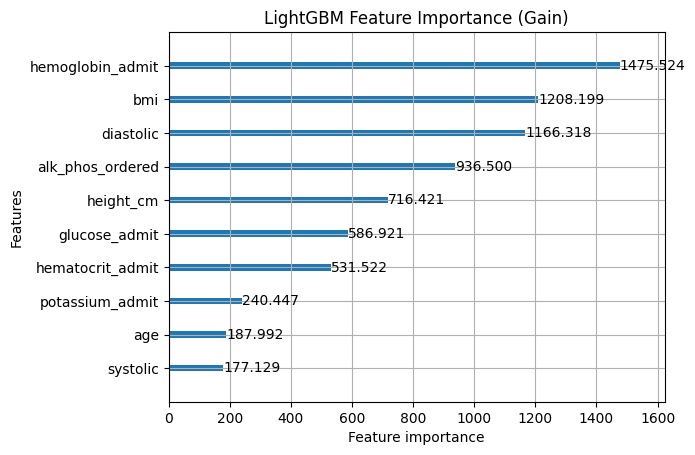

In [ ]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming 'model' is your trained LightGBM model (lgb.Booster or LGBMModel)
# Assuming 'feature_names' are your column names

# For LGBMModel (sklearn API)
if hasattr(model, 'feature_importances_'):
    print("Using LGBMModel feature_importances_ (split by default)")
    importances = model.feature_importances_
else: # For Booster model (native API)
    print("Using Booster feature_importance()")
    importances = model.feature_importance(importance_type='gain') # Or 'split'

# Plotting
lgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("LightGBM Feature Importance (Gain)")
plt.show()
